# Imports

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
import glob
import json
from google.colab.patches import cv2_imshow
from skimage import exposure
from skimage.exposure import match_histograms
from skimage import data
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import layers
import keras
import random
import keras.backend as K
from keras.utils.vis_utils import plot_model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Path and Dataset

In [ ]:
!unzip /content/drive/MyDrive/CV_project/Dataset.zip -d Dataset

In [ ]:
!unzip /content/drive/MyDrive/CV_project/Patterns.zip -d Patterns

In [ ]:
dataset_path = '/content/Dataset'
patterns_path = '/content/Patterns'

In [ ]:
dataset_images = glob.glob(dataset_path + '/*.jpg') + glob.glob(dataset_path + '/*.png') + glob.glob(dataset_path + '/*.bmp')
dataset_jsons = glob.glob(dataset_path + '/*.json')
patterns_images = glob.glob(patterns_path + '/*.tif')

Before doing any preprocessing, we should remove 2 outliers in dataset:


> 


    - 1644888256.0602736.bmp

> 


    - 1644888240.3566377.bmp

In [ ]:
dataset_info = {}
for d_path in dataset_jsons:
  with open(d_path) as f:
    info = json.load(f, encoding='utf8')
    dataset_info[info['imagePath']] = info

In [ ]:
patterns = {}
for p in patterns_images:
  p_name = p.split('/')[-1]
  pat = cv2.imread(p)
  patterns[p_name] = pat

images = {}
for im in dataset_images:
  if '1644888256.0602736.bmp' in im or '1644888240.3566377.bmp' in im:
      continue
  im_name = im.split('/')[-1]
  img = cv2.imread(im)
  images[im_name] = img

In [ ]:
len(list(images.keys()))

306

# Remove black margins

In [ ]:
def remove_pattern_noise(img): 
  gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  ret,otsu_thresh = cv2.threshold(gray_img,127,200,cv2.THRESH_BINARY)

  kernel = np.ones((39, 39), np.uint8)

  closing = cv2.morphologyEx(otsu_thresh, cv2.MORPH_CLOSE,
                            kernel, iterations=1)

  return cv2.Canny(np.uint8(closing), 80, 120)

In [ ]:
def find_vertices(im):
    contours, hierarchy = cv2.findContours(im, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

    Minn, area = None, 0
    for s in contours:
        area_hold = cv2.contourArea(s)
        if area_hold > area :
            Minn = s
            area = area_hold
    if Minn is None:
        return None
    return cv2.approxPolyDP(Minn, 0.01*cv2.arcLength(Minn,True),True)

In [ ]:
def crop_out(im, vertices):
    vertices = [vertices[0], vertices[3], vertices[1], vertices[2]]
    vertices = np.array(vertices, dtype=np.float32)
    width = math.ceil(np.sqrt(np.sum(np.power(vertices[0] - vertices[1], 2))))
    height = math.ceil(np.sqrt(np.sum(np.power(vertices[0] - vertices[2], 2))))
    target = np.float32([[0, 0], [width, 0],
                       [0, height], [width, height]])
    transform = cv2.getPerspectiveTransform(vertices, target)  # get the top or bird eye view effect
    return cv2.warpPerspective(im, transform, (width, height))

# Creating Masks

In [ ]:
def create_binary_masks(im, shape_dicts): 
    blank = np.zeros(shape=(im.shape[0], im.shape[1]), dtype=np.float32)
    for shape in shape_dicts:
        points = np.array(shape['points'], dtype=np.int32)
        cv2.fillPoly(blank, [points], 255)
    return blank

# Cropping images and Creating Masks

In [ ]:
crop_path = '/content/drive/MyDrive/CV_Presenetation/Crop/'

In [ ]:
mask_path = '/content/drive/MyDrive/CV_Presenetation/Mask/'

In [ ]:
for name, im in images.items():
    shapes = dataset_info[name]['shapes']
    mask = create_binary_masks(im, shapes)
    cv2.imwrite(mask_path + name, mask)

In [ ]:
for name, img in images.items():
    new_im = remove_pattern_noise(img)
    v = find_vertices(new_im)
    res = crop_out(img, v)
    mask = cv2.imread(mask_path + name)
    mask_crop = crop_out(mask, v)
    cv2.imwrite(crop_path + name, res)
    cv2.imwrite(mask_path + name, mask_crop)

In [ ]:
del images

# Useful functions

In [ ]:
def resize_img(img, desired_size = 1530):
    channels = 3
    old_size = img.shape
    ratio = float(desired_size) / max(old_size)
    new_size = (int(old_size[1] * ratio), int(old_size[0] * ratio))
    img = cv2.resize(img, new_size)
    diff_w = desired_size - new_size[0]
    diff_h = desired_size - new_size[1]
    top, bottom = diff_h//2, diff_h-(diff_h//2)
    left, right = diff_w//2, diff_w-(diff_w//2)
    new_img = np.zeros((desired_size, desired_size, channels), dtype=img.dtype)
    for i in range(channels):
      ch = img[:, :, i]
      new_ch = np.pad(ch, ((top, bottom),(left, right)), 'constant')
      new_img[:, :, i] = new_ch
    return new_img

In [ ]:
def hist_matching(img1, img2):
    matched = match_histograms(img2, img1)
    return cv2.normalize(matched, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')

def improve_contrast(img):
    lab= cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l_channel, a, b = cv2.split(lab)

    # Applying CLAHE to L-channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l_channel)

    # merge the CLAHE enhanced L-channel with the a and b channel
    limg = cv2.merge((cl,a,b))

    # Converting image from LAB Color model to BGR color spcae
    enhanced_img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

    return enhanced_img

# Loading Cropped Images and Resizing Patterns for Transformation

In [ ]:
crop_images = glob.glob(crop_path + '/*.jpg') + glob.glob(crop_path + '/*.png') + glob.glob(crop_path + '/*.bmp')

In [ ]:
cropped_ims = {}
for im in crop_images:
  im_name = im.split('/')[-1]
  img = cv2.imread(im)
  cropped_ims[im_name] = img

In [ ]:
for p_name in patterns:
    patterns[p_name] = resize_img(patterns[p_name])

# Finding Keypoints and Apply Transformation

In [ ]:
transformed_pattern_path = '/content/drive/MyDrive/CV_Presenetation/Transform/'

In [ ]:
missed_ones = []

In [ ]:
for name, img in cropped_ims.items():
    img2 = img
    pat_name = dataset_info[name]['pattern']
    img1 = patterns[pat_name]
    img2 = hist_matching(img1, img2)
    img2 = improve_contrast(img2)
    img1, img2 = img2, img1
    img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(img1_gray,None)
    kp2, des2 = sift.detectAndCompute(img2_gray,None)
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1,des2,k=2)
    # Apply ratio test
    good = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good.append([m])
    src_pts = np.float32([ kp1[m[0].queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m[0].trainIdx].pt for m in good ]).reshape(-1,1,2)
    if len(src_pts) >= 4:
        H ,mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0 )
        perspective_img = cv2.warpPerspective(img2, H, (img1.shape[1], img1.shape[0]))
        cv2.imwrite(transformed_pattern_path + pat_name.split('.')[0] + '_' + name, perspective_img )
    else:
        missed_ones.append(name)
        continue

In [ ]:
missed_ones

['1644428236.9963467.png',
 '1644434369.4772506.png',
 '1644441231.4249313.png',
 '1644880490.5008993.bmp',
 '1644879631.817003.bmp',
 '1644878967.7489526.bmp',
 '1644876249.3602998.bmp',
 '1644875773.6795602.bmp']

We failed to transform pattern for tiles that are present in **missed_ones** so we remove them from dataset.

In [ ]:
for miss in missed_ones:
    cropped_ims.pop(miss)

# sliding window

In [ ]:
def sliding_window(image, stepSize, windowSize):
    for y in range(0, image.shape[0], stepSize):
        for x in range(0, image.shape[1], stepSize):
            if y + windowSize[1] < image.shape[0] and x + windowSize[0] < image.shape[1]:
                yield [[x, y],[x + windowSize[0], y + windowSize[1]]]

In [ ]:
step_size = 50
window_size = (50, 50)
tereshhold=0
train1_fractured = []
train2_fractured = []
train1_without_fracture = []
train2_without_fracture = []
for name, img in cropped_ims.items():
    mask = cv2.imread(mask_path + name)
    pat_name = dataset_info[name]['pattern'].split('.')[0]
    pat_t_name = pat_name + "_" + name
    pat = cv2.imread(transformed_pattern_path + pat_t_name)
    if pat is None:
        continue
    for win_coordinates in sliding_window(img, step_size, window_size):
        x1=win_coordinates[0][0]
        y1=win_coordinates[0][1]
        x2=win_coordinates[1][0]
        y2=win_coordinates[1][1]
        masked_win = mask[y1:y2,x1:x2]
        pattern_win = pat[y1:y2,x1:x2]
        image_win = img[y1:y2,x1:x2]
        win_sum=np.sum(masked_win)
        if win_sum > tereshhold :
            train1_fractured.append(image_win)
            train2_fractured.append(pattern_win)
        else:
            train1_without_fracture.append(image_win)
            train2_without_fracture.append(pattern_win)

In [ ]:
print(f'with fracture: {len(train1_fractured)}')
print(f'without fracture: {len(train1_without_fracture)}')

with fracture: 2045
without fracture: 266935


In [ ]:
fracture_less = list(zip(train1_without_fracture, train2_without_fracture))
less_1=[]
less_2=[]
for a,b in random.sample(fracture_less, 3000):
    less_1.append(a)
    less_2.append(b)

In [ ]:
train1_t = train1_fractured + less_1
train2_t = train2_fractured + less_2
labels = []
for i in range(len(less_1)):
    labels += [1]

for i in range(len(train1_fractured)):
    labels += [0]

In [ ]:
labels_t = np.asarray(labels).astype(np.float32)

In [ ]:
train1 = np.array(train1_t)
del train1_t

In [ ]:
train2 = np.array(train2_t)
del train2_t

# Model

In [51]:
def euclidean_distance(vects):
    """Find the Euclidean distance between two vectors.

    Arguments:
        vects: List containing two tensors of same length.

    Returns:
        Tensor containing euclidean distance
        (as floating point value) between vectors.
    """

    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))


input = layers.Input((50, 50, 3))
x = tf.keras.layers.BatchNormalization()(input)
x = layers.Conv2D(4, (5, 5), activation="relu")(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(16, (5, 5), activation="relu")(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)

x = tf.keras.layers.BatchNormalization()(x)
x = layers.Dense(10, activation="relu")(x)
embedding_network = keras.Model(input, x)


input_1 = layers.Input((50, 50, 3))
input_2 = layers.Input((50, 50, 3))

# As mentioned above, Siamese Network share weights between
# tower networks (sister networks). To allow this, we will use
# same embedding network for both tower networks.
tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

merge_layer = layers.Lambda(euclidean_distance)([tower_1, tower_2])
normal_layer = tf.keras.layers.BatchNormalization()(merge_layer)
output_layer = layers.Dense(1, activation="sigmoid")(normal_layer)
siamese = keras.Model(inputs=[input_1, input_2], outputs=output_layer)

In [52]:
def loss(margin=1):
    """Provides 'constrastive_loss' an enclosing scope with variable 'margin'.

    Arguments:
        margin: Integer, defines the baseline for distance for which pairs
                should be classified as dissimilar. - (default is 1).

    Returns:
        'constrastive_loss' function with data ('margin') attached.
    """

    # Contrastive loss = mean( (1-true_value) * square(prediction) +
    #                         true_value * square( max(margin-prediction, 0) ))
    def contrastive_loss(y_true, y_pred):
        """Calculates the constrastive loss.

        Arguments:
            y_true: List of labels, each label is of type float32.
            y_pred: List of predictions of same length as of y_true,
                    each label is of type float32.

        Returns:
            A tensor containing constrastive loss as floating point value.
        """

        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return contrastive_loss

In [53]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [54]:
epochs = 10
batch_size = 32
margin = 1
siamese.compile(loss=loss(margin=margin), optimizer="adam", metrics=["accuracy", f1])
siamese.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 50, 50, 3)]  0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 50, 50, 3)]  0           []                               
                                                                                                  
 model_2 (Functional)           (None, 10)           20086       ['input_5[0][0]',                
                                                                  'input_6[0][0]']                
                                                                                                  
 lambda_1 (Lambda)              (None, 1)            0           ['model_2[0][0]',          

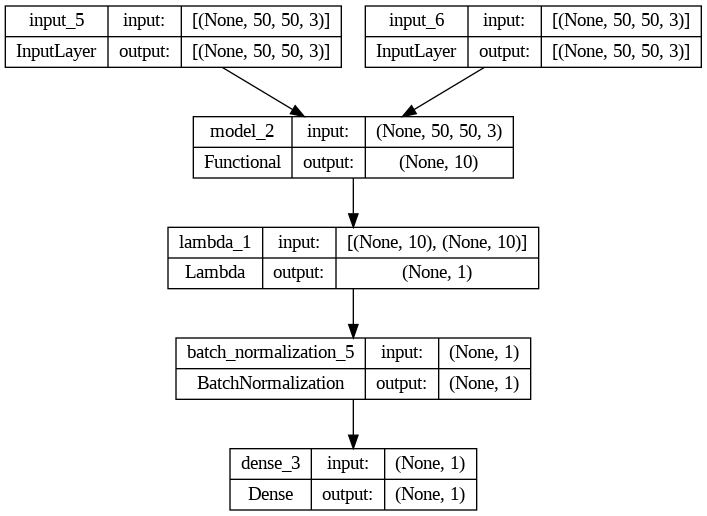

In [55]:
plot_model(siamese, show_shapes=True, show_layer_names=True)

In [56]:
history = siamese.fit(
    [train1, train2],
    labels_t,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
    shuffle=True
)

Epoch 1/10
127/127 [==============================] - 14s 101ms/step - loss: 0.2362 - accuracy: 0.6781 - f1: 0.7787 - val_loss: 0.1520 - val_accuracy: 0.9941 - val_f1: 0.0000e+00
Epoch 2/10
127/127 [==============================] - 12s 91ms/step - loss: 0.2163 - accuracy: 0.7101 - f1: 0.8078 - val_loss: 0.1063 - val_accuracy: 1.0000 - val_f1: 0.0000e+00
Epoch 3/10
127/127 [==============================] - 12s 91ms/step - loss: 0.1981 - accuracy: 0.7309 - f1: 0.8266 - val_loss: 0.0936 - val_accuracy: 0.9663 - val_f1: 0.0000e+00
Epoch 4/10
127/127 [==============================] - 11s 90ms/step - loss: 0.1843 - accuracy: 0.7413 - f1: 0.8349 - val_loss: 0.3123 - val_accuracy: 0.1308 - val_f1: 0.0000e+00
Epoch 5/10
127/127 [==============================] - 11s 90ms/step - loss: 0.1735 - accuracy: 0.7584 - f1: 0.8475 - val_loss: 0.3124 - val_accuracy: 0.1843 - val_f1: 0.0000e+00
Epoch 6/10
127/127 [==============================] - 12s 95ms/step - loss: 0.1657 - accuracy: 0.7693 - f1: 0